## Acerca del dataset Galaxy10 DECaLS

**https://astronn.readthedocs.io/en/latest/galaxy10.html**

El Galaxy10 DECaLS es un conjunto de datos que contiene **17,736 imágenes a color** de galaxias, cada una con una **resolución de 256x256 píxeles**.
Las mismas están clasificadas en 10 clases distintas, basadas en las etiquetas proporcionadas por el proyecto Galaxy Zoo.

Las clases y la cantidad de imágenes por clase son las siguientes:

- Clase 0: Galaxias perturbadas (1,081 imágenes)
- Clase 1: Galaxias en fusión (1,853 imágenes)
- Clase 2: Galaxias redondas y suaves (2,645 imágenes)
- Clase 3: Galaxias intermedias entre redondas y suaves (2,027 imágenes)
- Clase 4: Galaxias en forma de cigarro y suaves (334 imágenes)
- Clase 5: Galaxias espirales barradas (2,043 imágenes)
- Clase 6: Galaxias espirales apretadas sin barra (1,829 imágenes)
- Clase 7: Galaxias espirales sueltas sin barra (2,628 imágenes)
- Clase 8: Galaxias de canto sin bulbo (1,423 imágenes)
- Clase 9: Galaxias de canto con bulbo (1,873 imágenes)

### Objetivo
El obejtivo será entrenar distintos modelos de clasificación de las imágenes.

## Librerías

In [6]:
pip install astroNN > /dev/null


In [7]:
!pip install torchmetrics  > /dev/null
!pip install --upgrade --no-cache-dir gdown  > /dev/null

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from astroNN.datasets import galaxy10
from astroNN.datasets.galaxy10 import galaxy10cls_lookup
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time


import matplotlib.image as mpimg
import random
import os

import torchvision
import torchsummary
import torchmetrics
from torch.utils.tensorboard import SummaryWriter

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

## Cargar imágenes y etiquetas

In [9]:
# Cargar de imágenes y etiquetas
%%time
start = time.time()

images_original, labels_original = galaxy10.load_data()

end = time.time()
print(f"Tiempo de ejecución: {end - start} segs.")

/root/.astroNN/datasets/Galaxy10_DECals.h5 was found!
Tiempo de ejecución: 60.6501886844635 segs.
CPU times: user 52 s, sys: 7.49 s, total: 59.5 s
Wall time: 1min


## Análisis exploratorio



### Balanceo de clases
Como se observa a continuación, las clases no están balanceadas:

- Clase 4	(Cigar Shaped Smooth) representa el 1.9% del total de imágenes.
- Clase 0	(Disturbed) representa el 6.1% del total de imágenes.
- El resto de las clases representan entre el 8% y el 15% del total.

Cantidad de imágenes por clase:
Clase 0 (Disturbed): 1081 imágenes
Clase 1 (Merging): 1853 imágenes
Clase 2 (Round Smooth): 2645 imágenes
Clase 3 (Smooth, Cigar shaped): 2027 imágenes
Clase 4 (Cigar Shaped Smooth): 334 imágenes
Clase 5 (Barred Spiral): 2043 imágenes
Clase 6 (Unbarred Tight Spiral): 1829 imágenes
Clase 7 (Unbarred Loose Spiral): 2628 imágenes
Clase 8 (Edge-on without Bulge): 1423 imágenes
Clase 9 (Edge-on with Bulge): 1873 imágenes


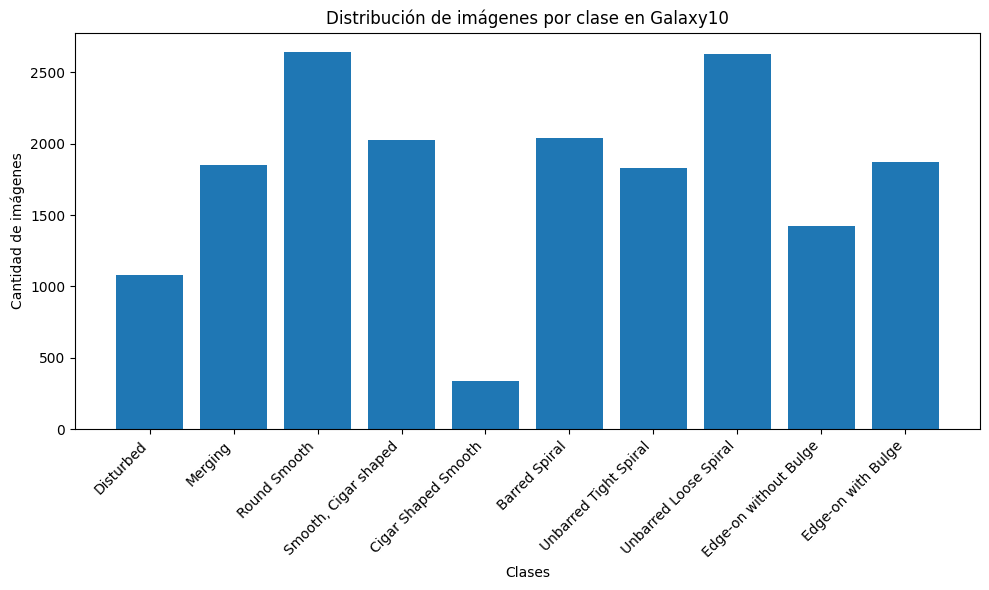

In [ ]:
#import numpy as np
#import matplotlib.pyplot as plt
#from astroNN.datasets import galaxy10
#from astroNN.datasets.galaxy10 import galaxy10cls_lookup
#import pandas as pd

# Contar la cantidad de imágenes por clase
unique_classes, counts = np.unique(labels_original, return_counts=True)

# Obtener nombres de las clases (opcional)
class_names = [galaxy10cls_lookup(cls) for cls in unique_classes]

# Mostrar la cantidad de imágenes por clase
print("Cantidad de imágenes por clase:")
for cls, name, count in zip(unique_classes, class_names, counts):
    print(f"Clase {cls} ({name}): {count} imágenes")

# Crear gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(unique_classes, counts, tick_label=class_names)
plt.xlabel("Clases")
plt.ylabel("Cantidad de imágenes")
plt.title("Distribución de imágenes por clase en Galaxy10")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [ ]:
#import pandas as pd

# Calcular el porcentaje de imágenes por clase
total_images = sum(counts)
percentages = [(count / total_images) * 100 for count in counts]

# Crear un DataFrame para visualizar la información
data = {
    "Clase": unique_classes,
    "Nombre": class_names,
    "Cantidad de Imágenes": counts,
    "Porcentaje (%)": percentages
}

df = pd.DataFrame(data)
pd.options.display.float_format = '{:,.1f}'.format

# Mostrar la cantidad total de imágenes
print(f"\nCantidad Total de Imágenes: {total_images}")

# Mostrar la tabla
print("\nDistribución de imágenes por clase\n")
display(df)

# Mostrar la tabla ordenada por porcentaje
df_sorted = df.sort_values(by="Porcentaje (%)", ascending=False)
display(df_sorted)



Cantidad Total de Imágenes: 17736

Distribución de imágenes por clase



Clase                 Nombre  Cantidad de Imágenes  Porcentaje (%)
0      0              Disturbed                  1081             6.1
1      1                Merging                  1853            10.4
2      2           Round Smooth                  2645            14.9
3      3   Smooth, Cigar shaped                  2027            11.4
4      4    Cigar Shaped Smooth                   334             1.9
5      5          Barred Spiral                  2043            11.5
6      6  Unbarred Tight Spiral                  1829            10.3
7      7  Unbarred Loose Spiral                  2628            14.8
8      8  Edge-on without Bulge                  1423             8.0
9      9     Edge-on with Bulge                  1873            10.6

Clase                 Nombre  Cantidad de Imágenes  Porcentaje (%)
2      2           Round Smooth                  2645            14.9
7      7  Unbarred Loose Spiral                  2628            14.8
5      5          Barred Spiral                  2043            11.5
3      3   Smooth, Cigar shaped                  2027            11.4
9      9     Edge-on with Bulge                  1873            10.6
1      1                Merging                  1853            10.4
6      6  Unbarred Tight Spiral                  1829            10.3
8      8  Edge-on without Bulge                  1423             8.0
0      0              Disturbed                  1081             6.1
4      4    Cigar Shaped Smooth                   334             1.9

### Visualizar ejemplos por clase

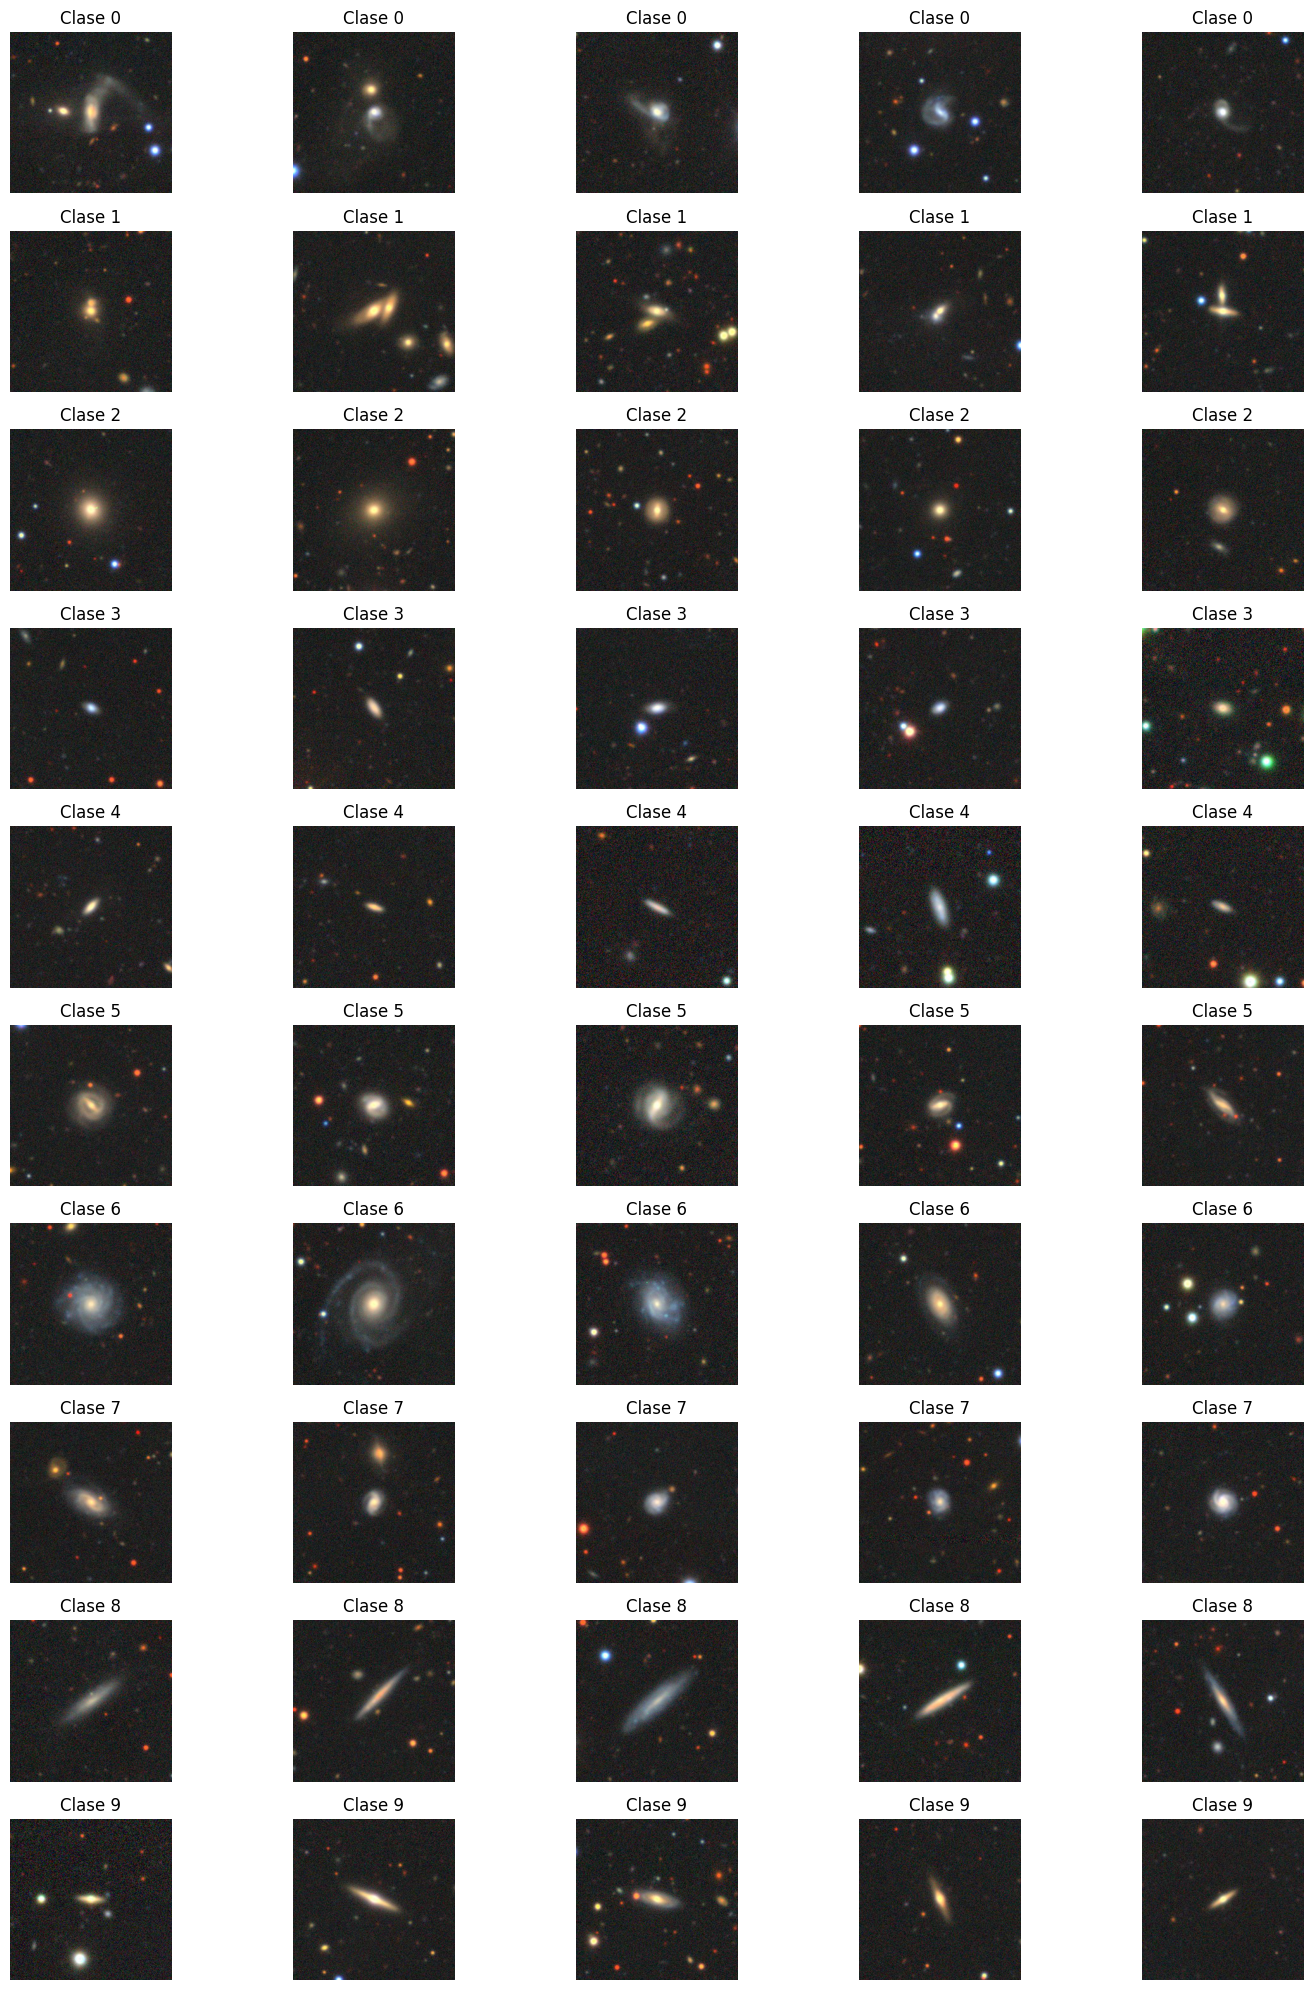

In [ ]:
# Visualizar 5 imágenes por clase
#import matplotlib.pyplot as plt
#import numpy as np

num_classes = len(unique_classes)
examples_per_class = 5

plt.figure(figsize=(15, num_classes * 2))
for cls in unique_classes:
    cls_indices = np.where(labels_original == cls)[0]
    for i in range(examples_per_class):
        plt.subplot(num_classes, examples_per_class, cls * examples_per_class + i + 1)
        plt.imshow(images_original[cls_indices[i]])
        plt.title(f"Clase {cls}")
        plt.axis("off")
plt.tight_layout()
plt.show()


### Dimesiones de las imágenes
Imágenes RGB de 256x256

In [ ]:
# Mostrar las dimensiones de las imágenes
image_shapes = [image.shape for image in images_original]
unique_shapes = np.unique(image_shapes, axis=0)
print(f"Formas únicas de imágenes: {unique_shapes}")


Formas únicas de imágenes: [[256 256   3]]


### Histograma de colores

Como muestra las imágenes, predomina los colores oscuros.

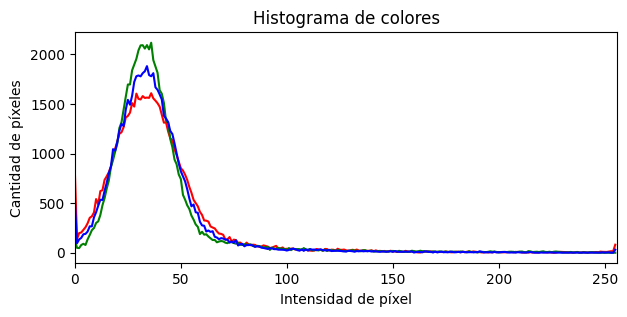

In [ ]:
# Calcular histograma de colores
import cv2

image = images_original[354]  # Usar una imagen de ejemplo
colors = ("r", "g", "b")
plt.figure(figsize=(7, 3))

for i, color in enumerate(colors):
    hist = cv2.calcHist([image], [i], None, [256], [0, 256])
    plt.plot(hist, color=color)
    plt.xlim([0, 256])

plt.title("Histograma de colores")
plt.xlabel("Intensidad de píxel")
plt.ylabel("Cantidad de píxeles")
plt.show()


### Media de valores de píxeles por clase

Las medias son similares, lo cual se podía presuponer debido a que en este dataset Galaxy10, en las imágenes el fondo (espacio oscuro) tiende a dominar, y las galaxias, que son los objetos principales, ocupan una pequeña parte de la imagen.

In [ ]:
df = []

from astroNN.datasets.galaxy10 import galaxy10cls_lookup

# Calcular la media de píxeles por clase
mean_pixel_values = []
for cls in unique_classes:
    cls_indices = np.where(labels_original == cls)[0]
    mean_pixel_value = np.mean(images_original[cls_indices], axis=(0, 1, 2))  # Promedio total, incluyendo canales
    mean_pixel_values.append((cls, mean_pixel_value))  # Guardar el número de clase y la media


for cls, mean in mean_pixel_values:
    class_name = galaxy10cls_lookup(cls)  # Obtener el nombre descriptivo de la clase
    #print(f"Clase {cls} ({class_name}): {mean}")  # Formatear el promedio como flotante
    data = {
      "Clase": cls,
      "Nombre": class_name,
      "Media de valores de píxeles ": mean
    }
    df.append(data)

df = pd.DataFrame(df)
# pd.options.display.float_format = '{:,.1f}'.format

# Mostrar la tabla
print("Media de valores de píxeles por clase\n")
display(df)


Media de valores de píxeles por clase



Clase                 Nombre  \
0      0              Disturbed   
1      1                Merging   
2      2           Round Smooth   
3      3   Smooth, Cigar shaped   
4      4    Cigar Shaped Smooth   
5      5          Barred Spiral   
6      6  Unbarred Tight Spiral   
7      7  Unbarred Loose Spiral   
8      8  Edge-on without Bulge   
9      9     Edge-on with Bulge   

                        Media de valores de píxeles   
0  [40.97591355682853, 40.25089071240279, 40.1543...  
1  [45.05331070102747, 43.359565343717854, 41.339...  
2  [42.02749737052701, 40.11565980965339, 38.2318...  
3  [40.19150447233827, 38.75701656633254, 37.4083...  
4  [38.83141724363772, 37.426919034855096, 36.671...  
5  [44.72679497433596, 43.9166339383193, 43.27048...  
6  [45.44995075474025, 44.69876276332215, 44.4416...  
7  [41.95919611102007, 41.50264986174655, 41.5926...  
8  [43.11615083524231, 42.277051173710774, 42.054...  
9  [41.612570563549035, 39.35430703720687, 37.771...

---
## **Arquitectura CNN**

Se experimentaron con tamaños de imagenes de 64x64 y 256x256 (tamaño original), y con distintos tamaños de dataset.

Además se entrenó con y sin Data Augmentation, aplicado solo al dataset de "entrenamiento". Las trasnformaciones aplicadas son:

- Re-dimensionamiento de las imagenes a 64x64.      
      transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)),
- Inversión de las imágenes, tanto en horizontal como vertical.
      transforms.RandomHorizontalFlip()
      transforms.RandomVerticalFlip()
- Rotacion de imágenes en X grados.
      transforms.RandomRotation(degrees=20)
- Recortar una porción (entre 40% y 70%) aleatoria de la imágen y redimensionarla al tamaño de entrenamiento.
      transforms.RandomResizedCrop(size=(64, 64), scale=(0.4, 0.7))
- Convertir un 50% de la imágenes a tonos grises.
      transforms.RandomGrayscale(0.5),



**Resumen de los resultados**

|Experimento|	Resolución|	Data Augmentation|	Accuracy|	Comentarios
| --- | --- | --- | --- | --- |
|1_1 Sin Data Augmentation|	64x64|	No|	100%	|Sobresaliente pero posiblemente sobreajustado.
|1_2 Con inversiones y escala grises|	64x64|	Flips, escala grises|	89%	|Mayor robustez, pero pérdida de rendimiento en ciertas clases.
|1_3 Con múltiples transformaciones|	64x64|	Flips, rotaciones, escala grises|	97%	|Balance ideal entre precisión y generalización.
|2_1 Sin Data Augmentation|	256x256|	No|	37%|	Sobreajuste claro, con desempeño bajo en validación.|
|2_2 Augmentation variado |256x256|	Flips, rotaciones, escala grises|	61%	|Generalización mejorada, pero aún lejos de un rendimiento óptimo.


### Función de entrenamiento

In [10]:
def train(model, optimizer, criterion, metric, data, epochs, tb_writer=None):

    train_loader = data["train"]
    valid_loader = data["valid"]

    train_writer = tb_writer["train"]
    valid_writer = tb_writer["valid"]

    if tb_writer:
        train_writer.add_graph(model, torch.zeros((1, 3, data["image_width"], data["image_height"])))
        valid_writer.add_graph(model, torch.zeros((1, 3, data["image_width"], data["image_height"])))

    if torch.cuda.is_available():
        model.to("cuda")
        metric.to("cuda")

    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    for epoch in range(epochs):

        # Pongo el modelo en modo entrenamiento
        model.train()

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:

            if torch.cuda.is_available():
                train_data = train_data.to("cuda")
                train_target = train_target.to("cuda")

            optimizer.zero_grad()
            output = model(train_data.float())
            loss = criterion(output, train_target)
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            accuracy = metric(output, train_target)
            epoch_train_accuracy += accuracy.item()

        epoch_train_loss = epoch_train_loss / len(train_loader)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_accuracy)

        # Pongo el modelo en modo testeo
        model.eval()

        epoch_valid_loss = 0.0
        epoch_valid_accuracy = 0.0

        for valid_data, valid_target in valid_loader:
            if torch.cuda.is_available():
                valid_data = valid_data.to("cuda")
                valid_target = valid_target.to("cuda")

            output = model(valid_data.float())
            epoch_valid_loss += criterion(output, valid_target).item()
            epoch_valid_accuracy += metric(output, valid_target).item()

        epoch_valid_loss = epoch_valid_loss / len(valid_loader)
        epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
        valid_loss.append(epoch_valid_loss)
        valid_acc.append(epoch_valid_accuracy)

        print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
        epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

        if tb_writer:
            train_writer.add_scalar("loss", epoch_train_loss, epoch)
            valid_writer.add_scalar("loss", epoch_valid_loss, epoch)
            train_writer.add_scalar("accuracy", epoch_train_accuracy, epoch)
            valid_writer.add_scalar("accuracy", epoch_valid_accuracy, epoch)
            train_writer.flush()
            valid_writer.flush()

    history = {}
    history["train_loss"] = train_loss
    history["train_acc"] = train_acc
    history["valid_loss"] = valid_loss
    history["valid_acc"] = valid_acc

    return history

### Definir sets de train, valid y test

In [20]:
# CANTIDAD_CLASES = 10
# ANCHO_IMAGENES = 64
# ALTO_IMAGENES = 64
total_images_to_use = 5000

In [21]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from astroNN.datasets import galaxy10
import numpy as np

# Paso 1: Cargar las imágenes y etiquetas del dataset Galaxy10. Se cargó tambien previamente para el Análisis Exploratorio.
try:
  print('')
  #if isinstance(images, np.ndarray) and isinstance(labels, np.ndarray):
  #  print("'images' y 'labels' es un numpy.ndarray")
  #else:
  #  print("Es necesario recargar el dataset de galaxy10.")
  #  images, labels = galaxy10.load_data()
except NameError:
  print('')
  #print("Es necesario recargar el dataset de galaxy10.")
  #images, labels = galaxy10.load_data()

finally:

  # Paso 2: Limitar la cantidad de imágenes para entrenamiento y validación
  # total_images_to_use = 200
  selected_indices = np.random.choice(len(images_original), total_images_to_use, replace=False)
  images = images_original[selected_indices]
  labels = labels_original[selected_indices]

  print(f"type(images): {type(images)}, type(labels){type(labels)}")

  print(f"Usando {len(images)} imágenes en total.")

  # Paso 3: Convertir las imágenes y etiquetas al formato necesario por PyTorch
  images = torch.tensor(images).permute(0, 3, 1, 2)  # Cambiar a formato [N, C, H, W]
  labels = torch.tensor(labels, dtype=torch.long)

  # Paso 4: Crear un Dataset personalizado
  class GalaxyDataset(Dataset):
      def __init__(self, images, labels, transform=None):
          self.images = images
          self.labels = labels
          self.transform = transform

      def __len__(self):
          return len(self.images)

      def __getitem__(self, idx):
          image = self.images[idx].float() / 255.0  # Normalización
          label = self.labels[idx]
          if self.transform:
              image = self.transform(image)
          return image, label

  # Crear el dataset completo (sin transformaciones por ahora)
  dataset = GalaxyDataset(images, labels)

  # Dividir en entrenamiento (80%) y validación (20%)
  train_size = int(0.8 * len(dataset))
  #valid_size = len(dataset) - train_size
  valid_size = int(0.1 * len(dataset)) #test#
  test_size = len(dataset) - train_size - valid_size #test#
  train_set, valid_set, test_set = random_split(dataset, [train_size, valid_size, test_size]) #test#

  # Aplicar transformaciones solo al conjunto de entrenamiento
  #train_transforms = transforms.Compose([
  #    transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)), # Resize de imagenes, inicialmente se prueba con 64x64.
  #])
  # Aplicar transformaciones solo al conjunto de validación
  #valid_transforms = transforms.Compose([
  #    transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)), # Resize de imagenes, inicialmente se prueba con 64x64.
  #])

  # Crear datasets transformados (aplicar transformaciones al train_set)
  # train_set.dataset = GalaxyDataset(train_set.dataset.images, train_set.dataset.labels, transform=train_transforms)
  #valid_set.dataset = GalaxyDataset(valid_set.dataset.images, valid_set.dataset.labels, transform=valid_transforms)

  # Crear los DataLoaders
  # train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
  #valid_loader = DataLoader(valid_set, batch_size=32, shuffle=False)

  # Paso 6: Inspeccionar los datos
  print(f"Tamaño del conjunto de entrenamiento: {len(train_set)}")
  print(f"Tamaño del conjunto de validación: {len(valid_set)}")
  print(f"Tamaño del conjunto de test: {len(test_set)}")

  # Ejemplo de iteración
  # for images_batch, labels_batch in train_loader:
  #    print(f"Batch de imágenes: {images_batch.shape}")
  #    print(f"Batch de etiquetas: {labels_batch.shape}")
  #    break



type(images): <class 'numpy.ndarray'>, type(labels)<class 'numpy.ndarray'>
Usando 5000 imágenes en total.
Tamaño del conjunto de entrenamiento: 4000
Tamaño del conjunto de validación: 500
Tamaño del conjunto de test: 500


In [13]:
# Funcion para visualizar ejemplos de imagenes de los datasets
import random
import matplotlib.pyplot as plt

def visualize_random_images(dataset, title, num_images=10):
    """
    Visualiza imágenes aleatorias de un dataset.
    """
    plt.figure(figsize=(15, num_images * 2))
    random_indices = random.sample(range(len(dataset)), num_images)  # Selección aleatoria
    for i, idx in enumerate(random_indices):
        image, label = dataset[idx]
        image = image.permute(1, 2, 0).numpy()  # Cambiar a formato HWC para visualización
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.title(f"{title}\nClase {label}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

---
### (1) Entrenamiento: tamaño de imagen 64x64



In [14]:
CANTIDAD_CLASES = 10
ANCHO_IMAGENES = 64
ALTO_IMAGENES = 64

#### Definir arquitectura de red neuronal

En la siguiente celda se define una clase para una red neuronal convolucional con 4 capas convolucionales, cada una seguida de un max pooling. Luego del último bloque convolucional-pooling se realiza un flatten y se agregan 2 capas densas para la clasificación.

Para que esta celda funcione se debe completar el valor de `in_features` de la primera capa densa, el cual se puede calcular sabiendo el tamaño de las imágenes de entrada a la red, y cómo afecta cada capa convolucional y de pooling a las dimensión del tensor de entrada de dicha capa densa.

In [15]:
class ConvModel(torch.nn.Module):
    def __init__(self, output_units):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding='same')
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding='same')
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same')
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same')
        self.pool4 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = torch.nn.Linear(in_features=2048, out_features=512)
        self.fc2 = torch.nn.Linear(in_features=512, out_features=output_units)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.pool3(torch.relu(self.conv3(x)))
        x = self.pool4(torch.relu(self.conv4(x)))
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

conv_model = ConvModel(CANTIDAD_CLASES)
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Si hay una GPU disponible muevo el modelo allí para aprovechar ese recurso
if torch.cuda.is_available():
    conv_model.to("cuda")


torchsummary.summary(conv_model, (3, ANCHO_IMAGENES, ALTO_IMAGENES))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             448
         MaxPool2d-2           [-1, 16, 32, 32]               0
            Conv2d-3           [-1, 32, 32, 32]           4,640
         MaxPool2d-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Conv2d-7            [-1, 128, 8, 8]          73,856
         MaxPool2d-8            [-1, 128, 4, 4]               0
            Linear-9                  [-1, 512]       1,049,088
           Linear-10                   [-1, 10]           5,130
Total params: 1,151,658
Trainable params: 1,151,658
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 1.18
Params size (MB): 4.39
Estimat

#### Definimos **valid_loader**

In [22]:
  valid_transforms = transforms.Compose([
      transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)), # Resize de imagenes, inicialmente se prueba con 64x64.
  ])

  valid_set_experimento_1 = GalaxyDataset(valid_set.dataset.images, valid_set.dataset.labels, transform=valid_transforms)
  valid_loader = DataLoader(valid_set_experimento_1, batch_size=32, shuffle=False)

#### Definimos **test_loader**

In [23]:
  test_transforms = transforms.Compose([
      transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)), # Resize de imagenes, inicialmente se prueba con 64x64.
  ])

  test_set_experimento_1 = GalaxyDataset(test_set.dataset.images, test_set.dataset.labels, transform=test_transforms)
  test_loader = DataLoader(test_set_experimento_1, batch_size=32, shuffle=False)

### Experimento 1_1, sin Data Augmentation
Solo se redimensionan las imagenes a 64x64

En los resultados se observa un alto rendimiento lo que indica que el modelo podría estar generalizando bien.

Sin embargo, al no haber aplicado Data Augmentation, las imágenes podrían no ser lo suficientemente diversas, lo que facilita que el modelo memorice patrones específicos en lugar de generalizar.

También, al haber reducido las imágenes a 64x64 se pueden estar perdiendo detalles importantes.

#### Definimos **train_loader** y tranformaciones

In [24]:
  # Aplicar transformaciones solo al conjunto de entrenamiento
  train_transforms = transforms.Compose([
      transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)), # Resize de imagenes, inicialmente se prueba con 64x64.
  ])

  train_set_experimento_1_1 = GalaxyDataset(train_set.dataset.images, train_set.dataset.labels, transform=train_transforms)

  train_loader = DataLoader(train_set_experimento_1_1, batch_size=32, shuffle=True)


In [25]:
# Obtener un batch del DataLoader y verificar las dimensiones
for images_batch, labels_batch in train_loader:
    print(f"Dimensiones del batch de imágenes: {images_batch.shape}")  # Esperado: [32, 3, 64, 64]
    break


Dimensiones del batch de imágenes: torch.Size([32, 3, 64, 64])


Ejemplos aleatorios del conjunto de entrenamiento (train_set):


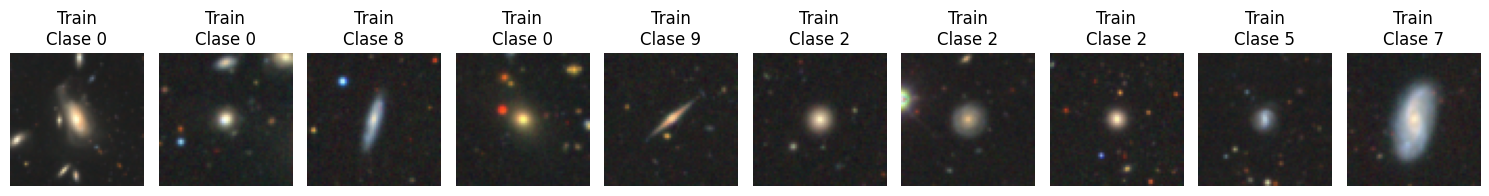

Ejemplos aleatorios del conjunto de validación (valid_set):


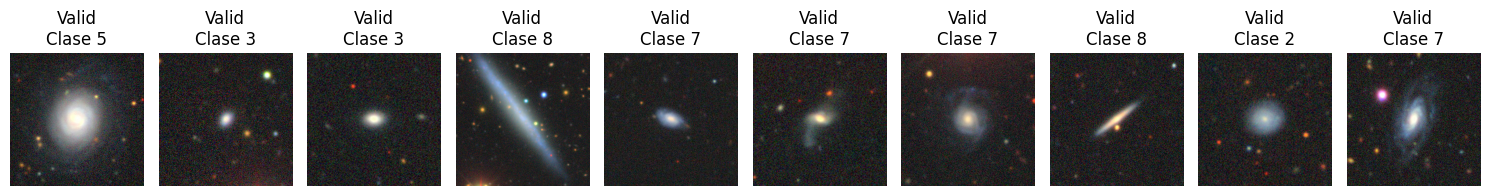

In [ ]:
### Mostrar aleatoriamente, imágenes ejemplo de 'train' y 'valid'
import random
import matplotlib.pyplot as plt

# Visualizar ejemplos aleatorios del conjunto de entrenamiento (con transformaciones aplicadas)
print("Ejemplos aleatorios del conjunto de entrenamiento (train_set):")
visualize_random_images(train_set_experimento_1_1, "Train")

# Visualizar ejemplos aleatorios del conjunto de validación (sin transformaciones)
print("Ejemplos aleatorios del conjunto de validación (valid_set):")
visualize_random_images(valid_set, "Valid")


#### Entrenamiento

Epoch: 1/50 - Train loss 2.129718 - Train Accuracy 0.196258 - Valid Loss 1.969804 - Valid Accuracy 0.248209
Epoch: 2/50 - Train loss 1.885631 - Train Accuracy 0.281847 - Valid Loss 1.692732 - Valid Accuracy 0.339570
Epoch: 3/50 - Train loss 1.596625 - Train Accuracy 0.404061 - Valid Loss 1.489053 - Valid Accuracy 0.449045
Epoch: 4/50 - Train loss 1.426175 - Train Accuracy 0.477707 - Valid Loss 1.297200 - Valid Accuracy 0.535629
Epoch: 5/50 - Train loss 1.287997 - Train Accuracy 0.531051 - Valid Loss 1.192447 - Valid Accuracy 0.559912
Epoch: 6/50 - Train loss 1.182373 - Train Accuracy 0.560709 - Valid Loss 1.162810 - Valid Accuracy 0.578424
Epoch: 7/50 - Train loss 1.084789 - Train Accuracy 0.600318 - Valid Loss 0.970325 - Valid Accuracy 0.650080
Epoch: 8/50 - Train loss 1.002084 - Train Accuracy 0.631170 - Valid Loss 0.985879 - Valid Accuracy 0.640725
Epoch: 9/50 - Train loss 0.937093 - Train Accuracy 0.660032 - Valid Loss 0.834327 - Valid Accuracy 0.703424
Epoch: 10/50 - Train loss 0.

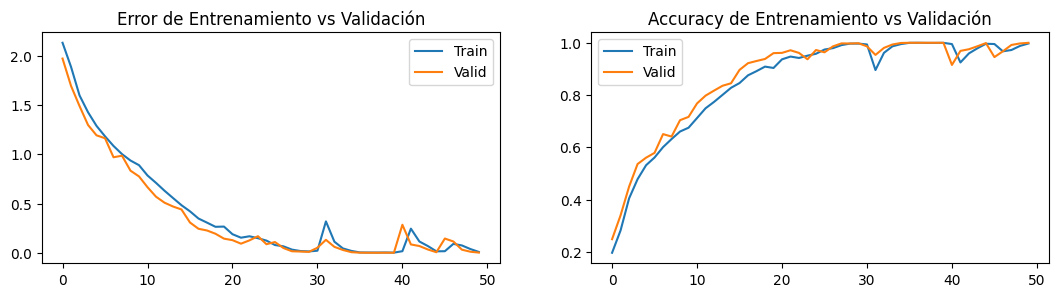

In [26]:
noaug_conv_model = ConvModel(CANTIDAD_CLASES)
noaug_optimizer = torch.optim.Adam(noaug_conv_model.parameters(), lr=0.001)
noaug_loss = torch.nn.CrossEntropyLoss()
noaug_metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES)
noaug_data = {"train": train_loader, "valid": valid_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}

noaug_writer = {"train": SummaryWriter(log_dir="data_aug/noaug_train"),
                "valid": SummaryWriter(log_dir="data_aug/noaug_valid")}

history = train(noaug_conv_model,
                noaug_optimizer,
                noaug_loss,
                noaug_metric,
                noaug_data,
                50,
                noaug_writer)


fig, axs = plt.subplots(1, 2, figsize=(13, 3))

axs[0].plot(history["train_loss"])
axs[0].plot(history["valid_loss"])
axs[0].title.set_text('Error de Entrenamiento vs Validación')
axs[0].legend(['Train', 'Valid'])

axs[1].plot(history["train_acc"])
axs[1].plot(history["valid_acc"])
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación')
axs[1].legend(['Train', 'Valid'])

#### Evaluacion con **test_loader**

In [27]:
#import torch
#from torch.utils.data import Dataset, DataLoader, random_split
#import torchvision.transforms as transforms
#from astroNN.datasets import galaxy10
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
#import numpy as np
#import matplotlib.pyplot as plt

Reporte de clasificación:
              precision    recall  f1-score   support

     Clase 0       1.00      1.00      1.00       307
     Clase 1       1.00      1.00      1.00       528
     Clase 2       1.00      1.00      1.00       731
     Clase 3       1.00      1.00      1.00       556
     Clase 4       1.00      1.00      1.00       100
     Clase 5       1.00      1.00      1.00       592
     Clase 6       1.00      1.00      1.00       512
     Clase 7       1.00      1.00      1.00       740
     Clase 8       1.00      1.00      1.00       390
     Clase 9       1.00      1.00      1.00       544

    accuracy                           1.00      5000
   macro avg       1.00      1.00      1.00      5000
weighted avg       1.00      1.00      1.00      5000



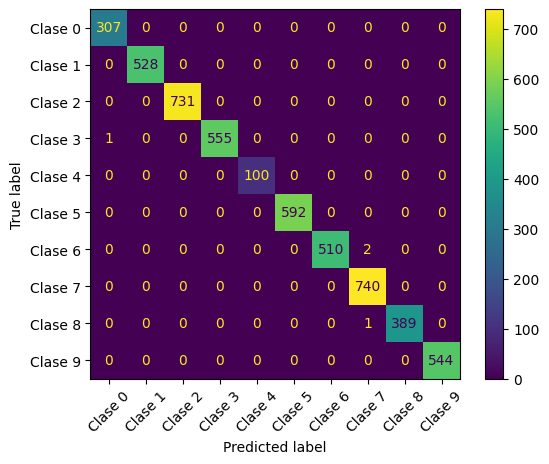

In [28]:
model = noaug_conv_model

# Paso 7: Evaluar el modelo en el conjunto de test
def evaluate_model(model, test_loader, device):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Reporte de clasificación
    print("Reporte de clasificación:")
    print(classification_report(y_true, y_pred, target_names=[f"Clase {i}" for i in range(10)]))

    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"Clase {i}" for i in range(10)])
    disp.plot(cmap="viridis", xticks_rotation=45)
    plt.show()

# Evaluar el modelo después del entrenamiento
device = "cuda" if torch.cuda.is_available() else "cpu"
evaluate_model(model, test_loader, device)

---
### Experimento 1_2, con Data Augmentation
Se aplican transformaciones, solamente de inversión y de tonos de grises.

El modelo logró un accuracy global de 89% con un desempeño razonable en varias clases. La incorporación de Data Augmentation mejoró la robustez del modelo, el cual se mostró más estable.

Sin embargo, la Clase 0, la cual estaba desbalanceada, tiene los peores resultados (con una precisión de 0.64 y F1-score de 0.75)

Las clases 1, 2, 4, 5, 7 y 9 tienen métricas superiores a 0.90, indicando un buen desempeño.

Clase 6 muestra un recall bajo (0.72), indicando que el modelo no está detectando correctamente todas las imágenes de esta clase. Esta imagen es de las galaxias de tipo espiral, las cuales muestran una mayor complejidad en la imágen.


In [29]:
  # Aplicar transformaciones solo al conjunto de entrenamiento
  aug_data_transforms = transforms.Compose([
      transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)), # Resize de imagenes, inicialmente se prueba con 64x64.
      transforms.RandomHorizontalFlip(),
      transforms.RandomVerticalFlip(),
      #transforms.RandomRotation(degrees=20),
      #transforms.RandomPerspective(0.4),
      #transforms.RandomResizedCrop(size=(64, 64), scale=(0.4, 0.7)),
      transforms.RandomGrayscale(0.5),
  ])

  # Crear datasets transformados (aplicar transformaciones al train_set)
  train_set_experimento_1_2 = GalaxyDataset(train_set.dataset.images, train_set.dataset.labels, transform=aug_data_transforms)

  # Crear los DataLoaders
  aug_train_loader = DataLoader(train_set_experimento_1_2, batch_size=32, shuffle=True)


Ejemplos aleatorios del conjunto de entrenamiento con Data Augmentation(train_set):


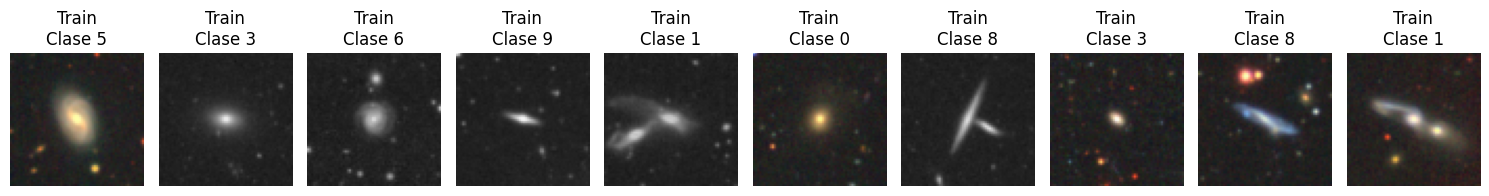

Ejemplos aleatorios del conjunto de validación sin Data Augmentation(valid_set):


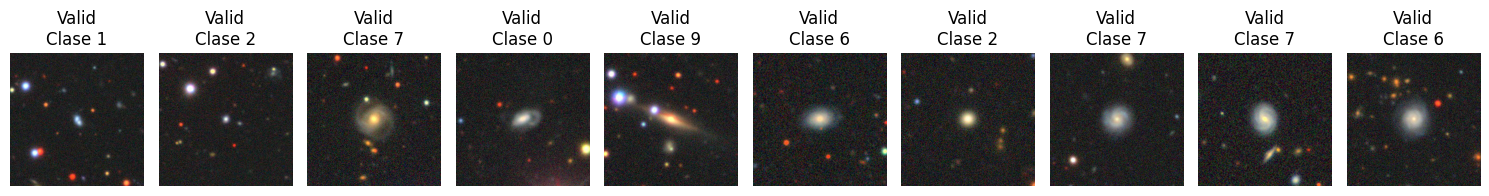

In [30]:
# Visualizar ejemplos aleatorios del conjunto de entrenamiento (con transformaciones aplicadas)
print("Ejemplos aleatorios del conjunto de entrenamiento con Data Augmentation(train_set):")
visualize_random_images(train_set_experimento_1_2, "Train")

# Visualizar ejemplos aleatorios del conjunto de validación (sin transformaciones)
print("Ejemplos aleatorios del conjunto de validación sin Data Augmentation(valid_set):")
visualize_random_images(valid_set, "Valid")


Epoch: 1/50 - Train loss 2.152528 - Train Accuracy 0.177747 - Valid Loss 2.000775 - Valid Accuracy 0.246616
Epoch: 2/50 - Train loss 1.900508 - Train Accuracy 0.282046 - Valid Loss 1.690935 - Valid Accuracy 0.358081
Epoch: 3/50 - Train loss 1.663607 - Train Accuracy 0.376791 - Valid Loss 1.564022 - Valid Accuracy 0.418392
Epoch: 4/50 - Train loss 1.480445 - Train Accuracy 0.461385 - Valid Loss 1.343859 - Valid Accuracy 0.506170
Epoch: 5/50 - Train loss 1.354576 - Train Accuracy 0.508559 - Valid Loss 1.232271 - Valid Accuracy 0.556728
Epoch: 6/50 - Train loss 1.267471 - Train Accuracy 0.540207 - Valid Loss 1.196718 - Valid Accuracy 0.572253
Epoch: 7/50 - Train loss 1.204493 - Train Accuracy 0.567476 - Valid Loss 1.092897 - Valid Accuracy 0.611266
Epoch: 8/50 - Train loss 1.157284 - Train Accuracy 0.584992 - Valid Loss 1.102796 - Valid Accuracy 0.614053
Epoch: 9/50 - Train loss 1.109305 - Train Accuracy 0.607683 - Valid Loss 1.008074 - Valid Accuracy 0.633161
Epoch: 10/50 - Train loss 1.

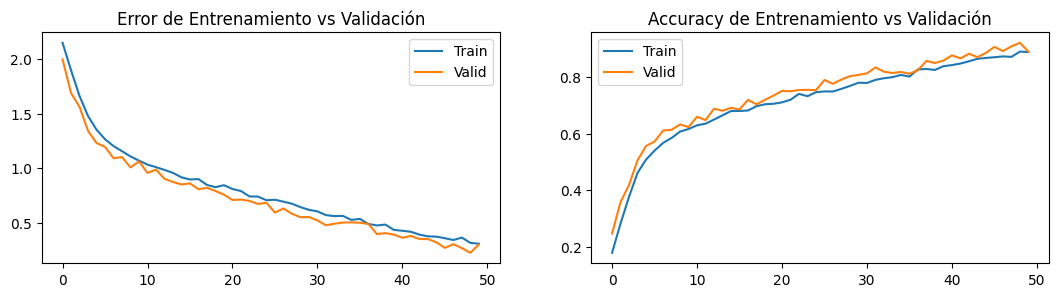

In [31]:
aug_conv_model = ConvModel(CANTIDAD_CLASES)
aug_optimizer = torch.optim.Adam(aug_conv_model.parameters(), lr=0.001)
aug_loss = torch.nn.CrossEntropyLoss()
aug_metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES)
aug_data = {"train": aug_train_loader, "valid": valid_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}

aug_writer = {"train": SummaryWriter(log_dir="data_aug/aug_train"),
              "valid": SummaryWriter(log_dir="data_aug/aug_valid")}

history = train(aug_conv_model,
                aug_optimizer,
                aug_loss,
                aug_metric,
                aug_data,
                50,
                aug_writer)

fig, axs = plt.subplots(1, 2, figsize=(13, 3))

axs[0].plot(history["train_loss"])
axs[0].plot(history["valid_loss"])
axs[0].title.set_text('Error de Entrenamiento vs Validación')
axs[0].legend(['Train', 'Valid'])

axs[1].plot(history["train_acc"])
axs[1].plot(history["valid_acc"])
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación')
axs[1].legend(['Train', 'Valid'])

Reporte de clasificación:
              precision    recall  f1-score   support

     Clase 0       0.64      0.89      0.75       307
     Clase 1       0.98      0.94      0.96       528
     Clase 2       0.99      0.94      0.96       731
     Clase 3       0.96      0.96      0.96       556
     Clase 4       0.92      0.96      0.94       100
     Clase 5       0.75      0.95      0.84       592
     Clase 6       0.94      0.72      0.82       512
     Clase 7       0.88      0.75      0.81       740
     Clase 8       0.89      0.99      0.94       390
     Clase 9       0.98      0.93      0.95       544

    accuracy                           0.89      5000
   macro avg       0.89      0.90      0.89      5000
weighted avg       0.90      0.89      0.89      5000



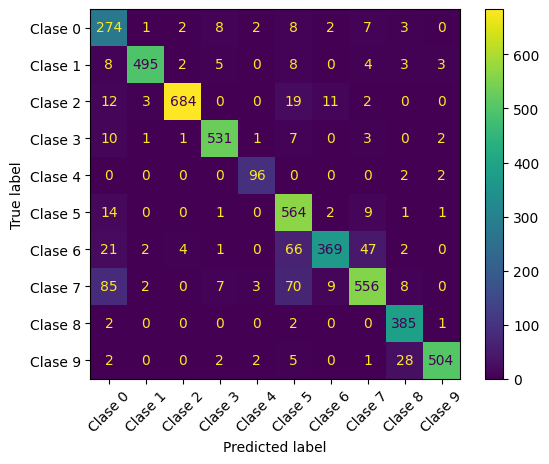

In [32]:
model = aug_conv_model

# Paso 7: Evaluar el modelo en el conjunto de test
def evaluate_model(model, test_loader, device):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Reporte de clasificación
    print("Reporte de clasificación:")
    print(classification_report(y_true, y_pred, target_names=[f"Clase {i}" for i in range(10)]))

    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"Clase {i}" for i in range(10)])
    disp.plot(cmap="viridis", xticks_rotation=45)
    plt.show()

# Evaluar el modelo después del entrenamiento
device = "cuda" if torch.cuda.is_available() else "cpu"
evaluate_model(model, test_loader, device)

### Experimento 1_3, con Data Augmentation

En este experimento se aplicaron múltiple transformaciones, permitiendo mejorar significativamente la capacidad del modelo para generalizar.

Con un accuracy de 97% y métricas consistentes entre clases, este modelo está más preparado para datos no vistos.

Clase 0 sigue siendo la más difícil de clasificar, con un recall de 0.92, pero su precisión mejoró a 0.95.

Clases como 1, 2, 4, 7 y 9 tienen métricas cercanas a 1.00, lo que muestra un desempeño muy sólido.

Clase 6 también mejoró notablemente con un recall de 0.89, mostrando que el modelo ahora es capaz de capturar mejor las características de esta clase.

In [33]:
  # Aplicar transformaciones solo al conjunto de entrenamiento
  aug_data_transforms = transforms.Compose([
      transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)), # Resize de imagenes, inicialmente se prueba con 64x64.
      transforms.RandomHorizontalFlip(),
      transforms.RandomVerticalFlip(),
      transforms.RandomRotation(degrees=40),
      #transforms.RandomPerspective(0.4),
      transforms.RandomResizedCrop(size=(64, 64), scale=(0.4, 0.7)),
      transforms.RandomGrayscale(0.5),
  ])

  # Crear datasets transformados (aplicar transformaciones al train_set)
  train_set_experimento_1_3 = GalaxyDataset(train_set.dataset.images, train_set.dataset.labels, transform=aug_data_transforms)

  # Crear los DataLoaders
  aug_train_loader = DataLoader(train_set_experimento_1_2, batch_size=32, shuffle=True)


Ejemplos aleatorios del conjunto de entrenamiento con Data Augmentation(train_set):


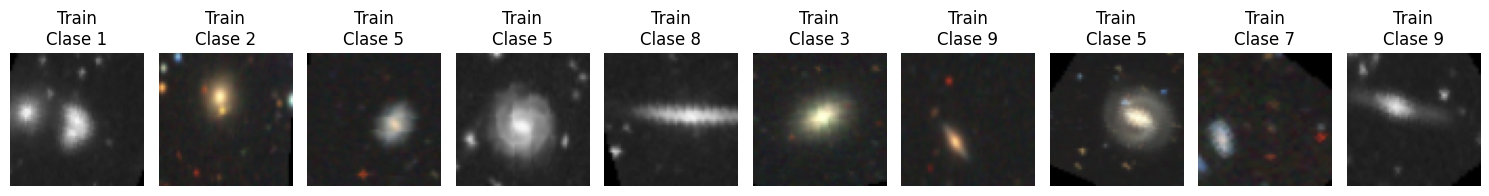

Ejemplos aleatorios del conjunto de validación sin Data Augmentation(valid_set):


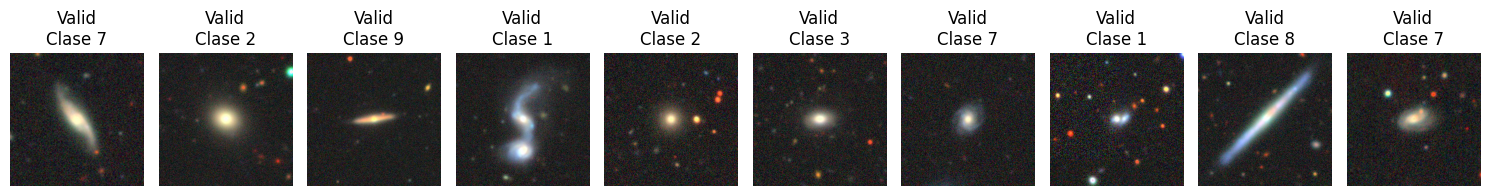

In [34]:
# Visualizar ejemplos aleatorios del conjunto de entrenamiento (con transformaciones aplicadas)
print("Ejemplos aleatorios del conjunto de entrenamiento con Data Augmentation(train_set):")
visualize_random_images(train_set_experimento_1_3, "Train")

# Visualizar ejemplos aleatorios del conjunto de validación (sin transformaciones)
print("Ejemplos aleatorios del conjunto de validación sin Data Augmentation(valid_set):")
visualize_random_images(valid_set, "Valid")


Epoch: 1/100 - Train loss 2.191813 - Train Accuracy 0.168591 - Valid Loss 2.012610 - Valid Accuracy 0.226115
Epoch: 2/100 - Train loss 1.961266 - Train Accuracy 0.247611 - Valid Loss 1.739965 - Valid Accuracy 0.347532
Epoch: 3/100 - Train loss 1.690082 - Train Accuracy 0.372213 - Valid Loss 1.485065 - Valid Accuracy 0.470939
Epoch: 4/100 - Train loss 1.496962 - Train Accuracy 0.448049 - Valid Loss 1.395602 - Valid Accuracy 0.485868
Epoch: 5/100 - Train loss 1.351648 - Train Accuracy 0.508758 - Valid Loss 1.257853 - Valid Accuracy 0.536823
Epoch: 6/100 - Train loss 1.272996 - Train Accuracy 0.543392 - Valid Loss 1.169353 - Valid Accuracy 0.576035
Epoch: 7/100 - Train loss 1.193139 - Train Accuracy 0.575239 - Valid Loss 1.090276 - Valid Accuracy 0.614650
Epoch: 8/100 - Train loss 1.178907 - Train Accuracy 0.570860 - Valid Loss 1.057042 - Valid Accuracy 0.617436
Epoch: 9/100 - Train loss 1.099474 - Train Accuracy 0.608280 - Valid Loss 1.091578 - Valid Accuracy 0.612858
Epoch: 10/100 - Tra

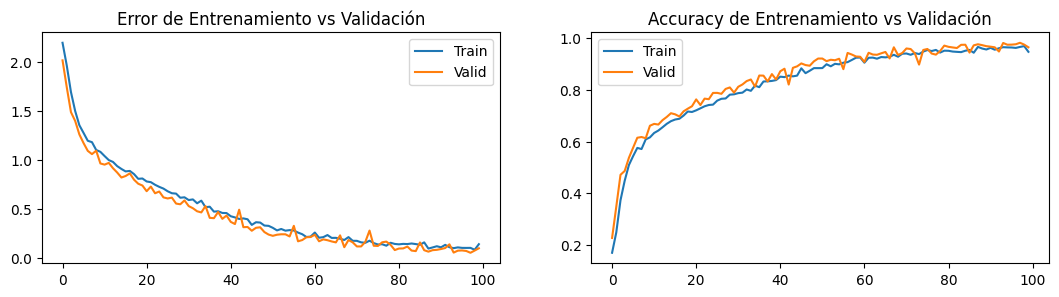

In [37]:
aug_conv_model_1_3 = ConvModel(CANTIDAD_CLASES)
aug_optimizer = torch.optim.Adam(aug_conv_model_1_3.parameters(), lr=0.001)
aug_loss = torch.nn.CrossEntropyLoss()
aug_metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES)
aug_data = {"train": aug_train_loader, "valid": valid_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}

aug_writer = {"train": SummaryWriter(log_dir="data_aug/aug_train"),
              "valid": SummaryWriter(log_dir="data_aug/aug_valid")}

history = train(aug_conv_model_1_3,
                aug_optimizer,
                aug_loss,
                aug_metric,
                aug_data,
                100,
                aug_writer)

fig, axs = plt.subplots(1, 2, figsize=(13, 3))

axs[0].plot(history["train_loss"])
axs[0].plot(history["valid_loss"])
axs[0].title.set_text('Error de Entrenamiento vs Validación')
axs[0].legend(['Train', 'Valid'])

axs[1].plot(history["train_acc"])
axs[1].plot(history["valid_acc"])
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación')
axs[1].legend(['Train', 'Valid'])

Reporte de clasificación:
              precision    recall  f1-score   support

     Clase 0       0.95      0.92      0.93       307
     Clase 1       0.99      0.98      0.99       528
     Clase 2       0.98      0.99      0.99       731
     Clase 3       1.00      0.95      0.97       556
     Clase 4       0.99      0.98      0.98       100
     Clase 5       0.99      0.94      0.97       592
     Clase 6       0.98      0.89      0.93       512
     Clase 7       0.87      0.99      0.92       740
     Clase 8       0.98      1.00      0.99       390
     Clase 9       1.00      0.98      0.99       544

    accuracy                           0.97      5000
   macro avg       0.97      0.96      0.97      5000
weighted avg       0.97      0.97      0.97      5000



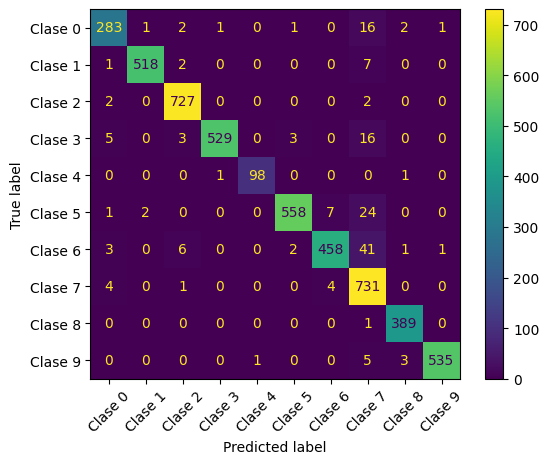

In [38]:
model = aug_conv_model_1_3

# Paso 7: Evaluar el modelo en el conjunto de test
def evaluate_model(model, test_loader, device):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Reporte de clasificación
    print("Reporte de clasificación:")
    print(classification_report(y_true, y_pred, target_names=[f"Clase {i}" for i in range(10)]))

    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"Clase {i}" for i in range(10)])
    disp.plot(cmap="viridis", xticks_rotation=45)
    plt.show()

# Evaluar el modelo después del entrenamiento
device = "cuda" if torch.cuda.is_available() else "cpu"
evaluate_model(model, test_loader, device)

## (2) Entrenamiento: tamaño de imagen 256x256


In [ ]:
CANTIDAD_CLASES = 10
ANCHO_IMAGENES = 256
ALTO_IMAGENES = 256
#total_images_to_use = 200

In [ ]:
import torch

class ConvModel(torch.nn.Module):
    def __init__(self, output_units):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding='same')
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding='same')
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same')
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same')
        self.pool4 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        # Ajuste de in_features de fc1
        self.fc1 = torch.nn.Linear(in_features=32768, out_features=512)
        self.fc2 = torch.nn.Linear(in_features=512, out_features=output_units)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.pool3(torch.relu(self.conv3(x)))
        x = self.pool4(torch.relu(self.conv4(x)))
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Crear una instancia del modelo
conv_model = ConvModel(output_units=10)  # Cambia "10" por la cantidad de clases en tu problema

# Enviar el modelo a GPU si está disponible
if torch.cuda.is_available():
    conv_model.to("cuda")

# Mostrar resumen del modelo
from torchsummary import summary
summary(conv_model, (3, 256, 256))  # (canales, altura, ancho)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             448
         MaxPool2d-2         [-1, 16, 128, 128]               0
            Conv2d-3         [-1, 32, 128, 128]           4,640
         MaxPool2d-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          18,496
         MaxPool2d-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
            Linear-9                  [-1, 512]      16,777,728
           Linear-10                   [-1, 10]           5,130
Total params: 16,880,298
Trainable params: 16,880,298
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 18.75
Params size (MB): 64.39
Est

### Experimento 2_1,  sin data augmentation
Imágenes en 256x256,

El uso de imágenes de 256x256 sin Data Augmentation resultó en un sobreajuste evidente.

Aunque el modelo aprendió perfectamente los datos de entrenamiento, su rendimiento en validación fue muy pobre (37% de accuracy).


In [ ]:

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_set , batch_size=32, shuffle=False)

In [ ]:
# Obtener un batch del DataLoader y verificar las dimensiones
for images_batch, labels_batch in train_loader:
    print(f"Dimensiones del batch de imágenes: {images_batch.shape}")  # Esperado: [32, 3, 64, 64]
    break

Dimensiones del batch de imágenes: torch.Size([32, 3, 256, 256])


Ejemplos aleatorios del conjunto de entrenamiento con Data Augmentation(train_set):


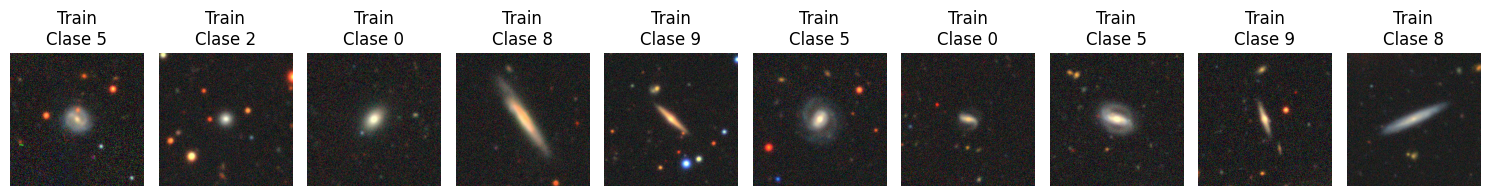

Ejemplos aleatorios del conjunto de validación sin Data Augmentation(valid_set):


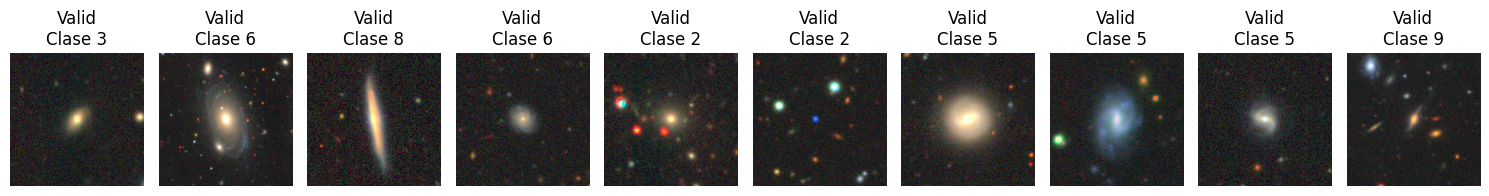

In [ ]:
# Visualizar ejemplos aleatorios del conjunto de entrenamiento (con transformaciones aplicadas)
print("Ejemplos aleatorios del conjunto de entrenamiento con Data Augmentation(train_set):")
visualize_random_images(train_set, "Train")

# Visualizar ejemplos aleatorios del conjunto de validación (sin transformaciones)
print("Ejemplos aleatorios del conjunto de validación sin Data Augmentation(valid_set):")
visualize_random_images(valid_set, "Valid")


Epoch: 1/50 - Train loss 2.224842 - Train Accuracy 0.159167 - Valid Loss 2.077325 - Valid Accuracy 0.206250
Epoch: 2/50 - Train loss 1.966117 - Train Accuracy 0.270417 - Valid Loss 1.886716 - Valid Accuracy 0.284375
Epoch: 3/50 - Train loss 1.717638 - Train Accuracy 0.357500 - Valid Loss 1.778526 - Valid Accuracy 0.307292
Epoch: 4/50 - Train loss 1.494433 - Train Accuracy 0.438333 - Valid Loss 1.714786 - Valid Accuracy 0.334375
Epoch: 5/50 - Train loss 1.241874 - Train Accuracy 0.545000 - Valid Loss 1.789981 - Valid Accuracy 0.362500
Epoch: 6/50 - Train loss 0.866766 - Train Accuracy 0.693333 - Valid Loss 2.238788 - Valid Accuracy 0.369792
Epoch: 7/50 - Train loss 0.492707 - Train Accuracy 0.828333 - Valid Loss 2.934000 - Valid Accuracy 0.337500
Epoch: 8/50 - Train loss 0.230674 - Train Accuracy 0.923333 - Valid Loss 3.853696 - Valid Accuracy 0.350000
Epoch: 9/50 - Train loss 0.109507 - Train Accuracy 0.971250 - Valid Loss 4.929654 - Valid Accuracy 0.343750
Epoch: 10/50 - Train loss 0.

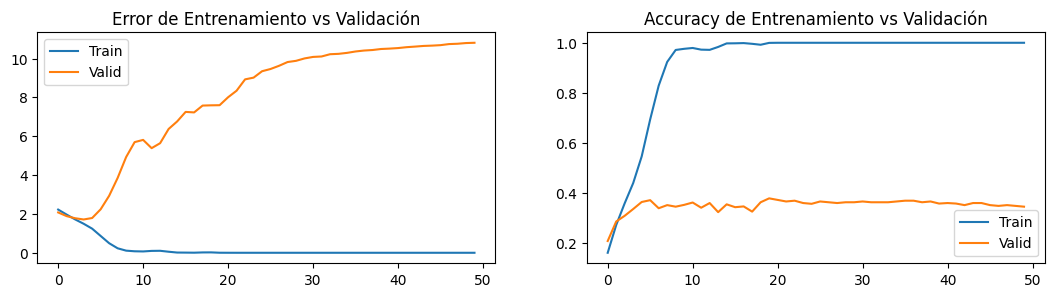

In [ ]:
noaug_conv_model = ConvModel(CANTIDAD_CLASES)
noaug_optimizer = torch.optim.Adam(noaug_conv_model.parameters(), lr=0.001)
noaug_loss = torch.nn.CrossEntropyLoss()
noaug_metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES)
noaug_data = {"train": train_loader, "valid": valid_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}

noaug_writer = {"train": SummaryWriter(log_dir="data_aug/noaug_train"),
                "valid": SummaryWriter(log_dir="data_aug/noaug_valid")}

history = train(noaug_conv_model,
                noaug_optimizer,
                noaug_loss,
                noaug_metric,
                noaug_data,
                50,
                noaug_writer)



fig, axs = plt.subplots(1, 2, figsize=(13, 3))

axs[0].plot(history["train_loss"])
axs[0].plot(history["valid_loss"])
axs[0].title.set_text('Error de Entrenamiento vs Validación')
axs[0].legend(['Train', 'Valid'])

axs[1].plot(history["train_acc"])
axs[1].plot(history["valid_acc"])
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación')
axs[1].legend(['Train', 'Valid'])

Reporte de clasificación:
              precision    recall  f1-score   support

     Clase 0       0.12      0.12      0.12        16
     Clase 1       0.27      0.27      0.27        37
     Clase 2       0.44      0.35      0.39        48
     Clase 3       0.42      0.37      0.39        41
     Clase 4       0.00      0.00      0.00         1
     Clase 5       0.39      0.38      0.39        39
     Clase 6       0.32      0.39      0.35        28
     Clase 7       0.33      0.41      0.37        41
     Clase 8       0.79      0.68      0.73        22
     Clase 9       0.33      0.33      0.33        27

    accuracy                           0.37       300
   macro avg       0.34      0.33      0.33       300
weighted avg       0.38      0.37      0.37       300



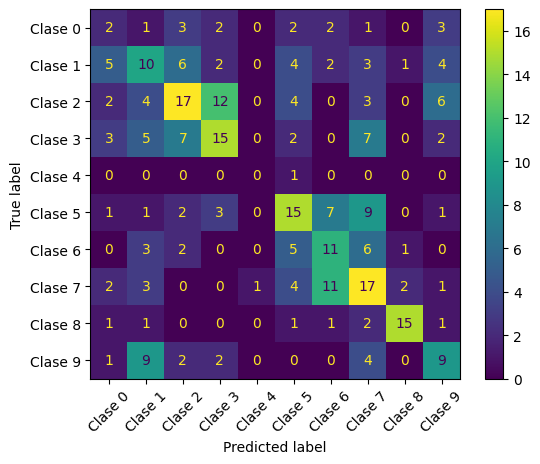

In [ ]:
model = noaug_conv_model

# Paso 7: Evaluar el modelo en el conjunto de test
def evaluate_model(model, test_loader, device):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Reporte de clasificación
    print("Reporte de clasificación:")
    print(classification_report(y_true, y_pred, target_names=[f"Clase {i}" for i in range(10)]))

    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"Clase {i}" for i in range(10)])
    disp.plot(cmap="viridis", xticks_rotation=45)
    plt.show()

# Evaluar el modelo después del entrenamiento
device = "cuda" if torch.cuda.is_available() else "cpu"
evaluate_model(model, test_loader, device)

### Experimento 2_2, con Data Augmentation

Imágenes en 256x256

El uso de 256x256 con Data Augmentation ha mejorado significativamente el desempeño del modelo en comparación con no usar augmentación. Sin embargo, el accuracy global (61%) muestran que aún queda margen de mejora.

La clase 0 tiene errores dispersos, siendo confundida con varias clases (por ejemplo, 1, 2, y 8).

La clase 3 y clase 7 también presentan confusiones significativas con otras clases.

Las clases mejor clasificadas son las clases 2 y 4 con un alto porcentaje de aciertos.


In [ ]:
  # Aplicar transformaciones solo al conjunto de entrenamiento
  aug_data_transforms = transforms.Compose([
      transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)), # Resize de imagenes, inicialmente se prueba con 64x64.
      transforms.RandomHorizontalFlip(),
      transforms.RandomVerticalFlip(),
      transforms.RandomRotation(degrees=40),
      #transforms.RandomPerspective(0.4),
      transforms.RandomResizedCrop(size=(256, 256), scale=(0.3, 0.7)),
      transforms.RandomGrayscale(0.5),
  ])

  # Crear datasets transformados (aplicar transformaciones al train_set)
  train_set_experimento_2_2 = GalaxyDataset(train_set.dataset.images, train_set.dataset.labels, transform=aug_data_transforms)

  # Crear los DataLoaders
  aug_train_loader = DataLoader(train_set_experimento_2_2, batch_size=64, shuffle=True)


Ejemplos aleatorios del conjunto de entrenamiento con Data Augmentation(train_set):


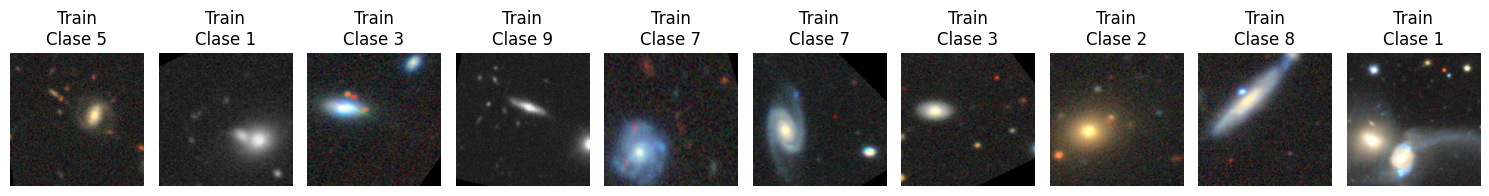

Ejemplos aleatorios del conjunto de validación sin Data Augmentation(valid_set):


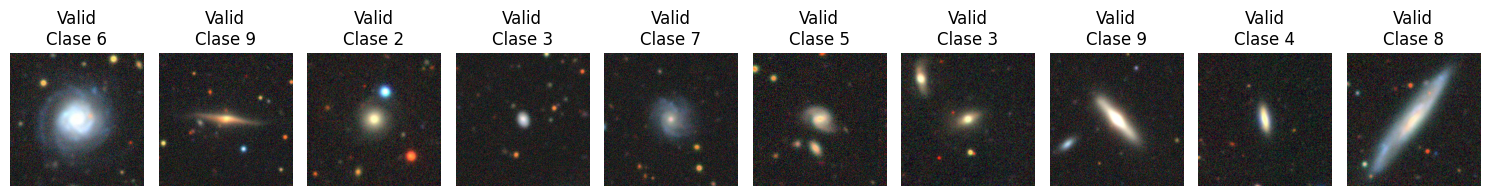

In [ ]:
# Visualizar ejemplos aleatorios del conjunto de entrenamiento (con transformaciones aplicadas)
print("Ejemplos aleatorios del conjunto de entrenamiento con Data Augmentation(train_set):")
visualize_random_images(train_set_experimento_2_2, "Train")

# Visualizar ejemplos aleatorios del conjunto de validación (sin transformaciones)
print("Ejemplos aleatorios del conjunto de validación sin Data Augmentation(valid_set):")
visualize_random_images(valid_set, "Valid")


In [ ]:
aug_conv_model = ConvModel(CANTIDAD_CLASES)
aug_optimizer = torch.optim.Adam(aug_conv_model.parameters(), lr=0.001)
aug_loss = torch.nn.CrossEntropyLoss()
aug_metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES)
aug_data = {"train": aug_train_loader, "valid": valid_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}

aug_writer = {"train": SummaryWriter(log_dir="data_aug/aug_train"),
              "valid": SummaryWriter(log_dir="data_aug/aug_valid")}

history = train(aug_conv_model,
                aug_optimizer,
                aug_loss,
                aug_metric,
                aug_data,
                50,
                aug_writer)

fig, axs = plt.subplots(1, 2, figsize=(13, 3))

axs[0].plot(history["train_loss"])
axs[0].plot(history["valid_loss"])
axs[0].title.set_text('Error de Entrenamiento vs Validación')
axs[0].legend(['Train', 'Valid'])

axs[1].plot(history["train_acc"])
axs[1].plot(history["valid_acc"])
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación')
axs[1].legend(['Train', 'Valid'])

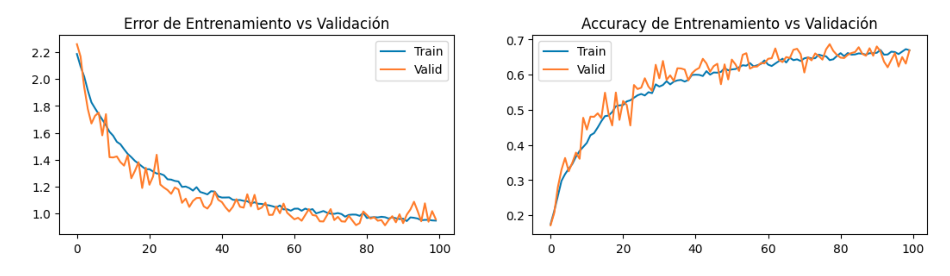

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Ruta de la imagen a cargar
img_path = "/content/2024-12-01__22-28-48_256x256_6000imagenes_ConDataAug_reporte.png"

# Cargar y mostrar la imagen
img = mpimg.imread(img_path)
plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.axis("off")  # Opcional: Quitar ejes
plt.show()

In [ ]:
model = aug_conv_model

# Paso 7: Evaluar el modelo en el conjunto de test
def evaluate_model(model, test_loader, device):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Reporte de clasificación
    print("Reporte de clasificación:")
    print(classification_report(y_true, y_pred, target_names=[f"Clase {i}" for i in range(10)]))

    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"Clase {i}" for i in range(10)])
    disp.plot(cmap="viridis", xticks_rotation=45)
    plt.show()

# Evaluar el modelo después del entrenamiento
device = "cuda" if torch.cuda.is_available() else "cpu"
evaluate_model(model, test_loader, device)

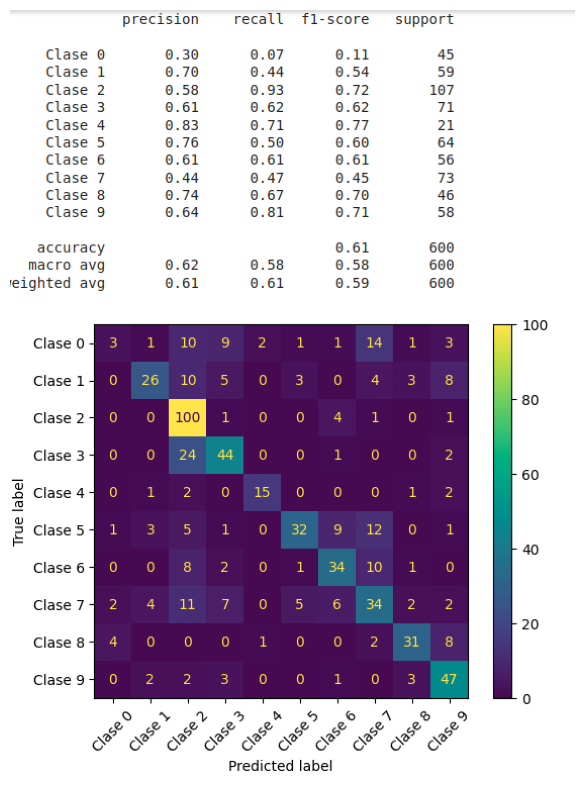

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Ruta de la imagen a cargar
img_path = "/content/2024-12-01__22-28-48_256x256_6000imagenes_ConDataAug_matrixConf.png"

# Cargar y mostrar la imagen
img = mpimg.imread(img_path)
plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.axis("off")  # Opcional: Quitar ejes
plt.show()

---
